# Određivanje rastojanja do M2 fitovanjem izohrone (stellar evolutionary track)

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import numpy as np
import pandas as pd
from speclite import filters 

import astropy.coordinates as coords
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

%matplotlib inline

## Pribavljanje podataka o jatu (M2 i još nekih koje upadaju u footprint SDSS-a)

podaci jata sa https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dmwsc&Action=More+Options

In [4]:
jataR = pd.read_table('globjatSDSShas')

#pretvanje jedinica za SQL pretragu
ra = 15 * (jataR['ra_h'] + jataR['ra_m']/60 + jataR['ra_s']/3600)
dec = jataR['dec_d'] + jataR['dec_m']/60
radius = np.ceil(jataR['central_radius_deg']*60)

jataR


,nameNGC,nameM,ra_h,ra_m,ra_s,dec_d,dec_m,lii_deg,bii_deg,core_radius_deg,central_radius_deg,cluster_radius_deg,distance_pc
0,NGC7089,M2,21,33,27,0,-49.4,53.371,-35.770,0.060,0.140,0.260,11507
1,NGC5272,M3,13,42,12,28,22.6,42.216,78.707,0.065,0.270,0.440,10194
2,NGC5904,M5,15,18,33,2,4.9,3.858,46.797,0.065,0.250,0.440,7501
3,NGC6205,M13,16,41,41,36,27.6,59.008,40.913,0.075,0.275,0.470,7107
4,NGC7078,M15,21,29,58,12,10.0,65.012,-27.312,0.050,0.185,0.350,10392
5,NGC5024,M53,13,12,55,18,10.1,332.959,79.764,0.035,0.150,0.250,17892
6,NGC6341,M92,17,17,7,43,8.2,68.338,34.859,0.060,0.240,0.405,8292


## Definisanje funkcija za SQL pretragu u SDSS-u

### uzima se radijus pretrage naveden gore kao central_radius_deg

In [5]:
def sql_SDSS_all(ra, dec, radius):
    
    sql = f"SELECT p.objid, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z   \
            FROM                                                   \
            photoObj p, dbo.fGetNearbyObjEq{ra, dec, radius} n     \
            WHERE                                                  \
            p.objID = n.objID                                      \
            and p.type = 6"
    
    return sql

def sql_SDSS_fit(ra, dec, radius):
    
    sql = f"SELECT p.objid, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, \
            sp.teffspec, sp.loggspec, sp.fehspec      \
            FROM                                                                   \
            dbo.fGetNearbyObjEq{ra, dec, radius} n                                                             \
            JOIN photoObj p ON  p.objID = n.objID    \
            JOIN sppparams sp ON n.objID = sp.bestobjid                            \
            WHERE                                                                                       \
            p.type = 6"
    
    return sql


### rezultati pretrage

In [6]:
SQ_M2a = sql_SDSS_all(ra[0], dec[0], radius[0])
Sdf2a = SDSS.query_sql(SQ_M2a).to_pandas()
#Sdf2a

SQ_M2f = sql_SDSS_fit(ra[0], dec[0], radius[0])
Sdf2f = SDSS.query_sql(SQ_M2f).to_pandas()
#Sdf2f


In [16]:
Sdf2a

,objid,ra,dec,u,g,r,i,z
0,1237663478180610973,323.282981,-0.759654,21.46835,20.39123,20.11437,19.96150,19.93640
1,1237663478180611402,323.282317,-0.752320,22.47142,21.73401,21.27377,21.10451,20.86828
2,1237663478180611405,323.283720,-0.752229,24.24456,24.36006,22.30200,22.15717,21.95460
3,1237663478180610909,323.279945,-0.756913,23.85310,22.10001,21.68421,21.36341,21.41399
4,1237663478180610911,323.279603,-0.753933,24.53849,21.99525,22.19185,21.71429,22.00558
...,...,...,...,...,...,...,...,...
2804,1237679028109051270,323.324898,-0.952270,22.78793,21.91655,21.40591,21.12593,21.06374
2805,1237679028109051277,323.327323,-0.946000,23.46746,21.54439,21.07818,21.00287,21.23465
2806,1237679028109051278,323.326287,-0.945892,24.61160,22.10573,21.68950,21.35602,21.87303
2807,1237679028109051434,323.314353,-0.929355,25.09764,22.93882,21.31649,19.83930,19.20206


## Generisanje izohrone 

### Neophodne informacije: metaličnost i starost jata

Izohrona generisana na i preuzeta sa: http://stellar.dartmouth.edu/models/isolf_new.html

In [8]:
iso = pd.read_csv('isochrones.txt', sep="\t", header = 0)
iso

,#EEP,M/Mo,LogTeff,LogG,LogL/Lo,sdss_u,sdss_g,sdss_r,sdss_i,sdss_z
0,13,0.111966,3.5386,5.3275,-2.7324,17.6848,14.0036,12.3306,11.5569,11.1422
1,14,0.123553,3.5458,5.2773,-2.6108,17.0951,13.5937,11.9600,11.2372,10.8428
2,15,0.137093,3.5532,5.2283,-2.4871,16.5147,13.1787,11.5880,10.9115,10.5374
3,16,0.151921,3.5600,5.1874,-2.3742,16.0019,12.8015,11.2528,10.6138,10.2577
4,17,0.166341,3.5658,5.1569,-2.2812,15.5883,12.4917,10.9798,10.3692,10.0273
...,...,...,...,...,...,...,...,...,...,...
262,275,0.814896,3.6214,0.5981,3.1904,1.1811,-1.6914,-2.8617,-3.3102,-3.5718
263,276,0.814900,3.6198,0.5676,3.2140,1.1968,-1.7206,-2.9076,-3.3629,-3.6288
264,277,0.814905,3.6182,0.5384,3.2367,1.2124,-1.7483,-2.9518,-3.4138,-3.6837
265,278,0.814909,3.6166,0.5100,3.2587,1.2282,-1.7747,-2.9943,-3.4631,-3.7371


## Plot sirovih podataka

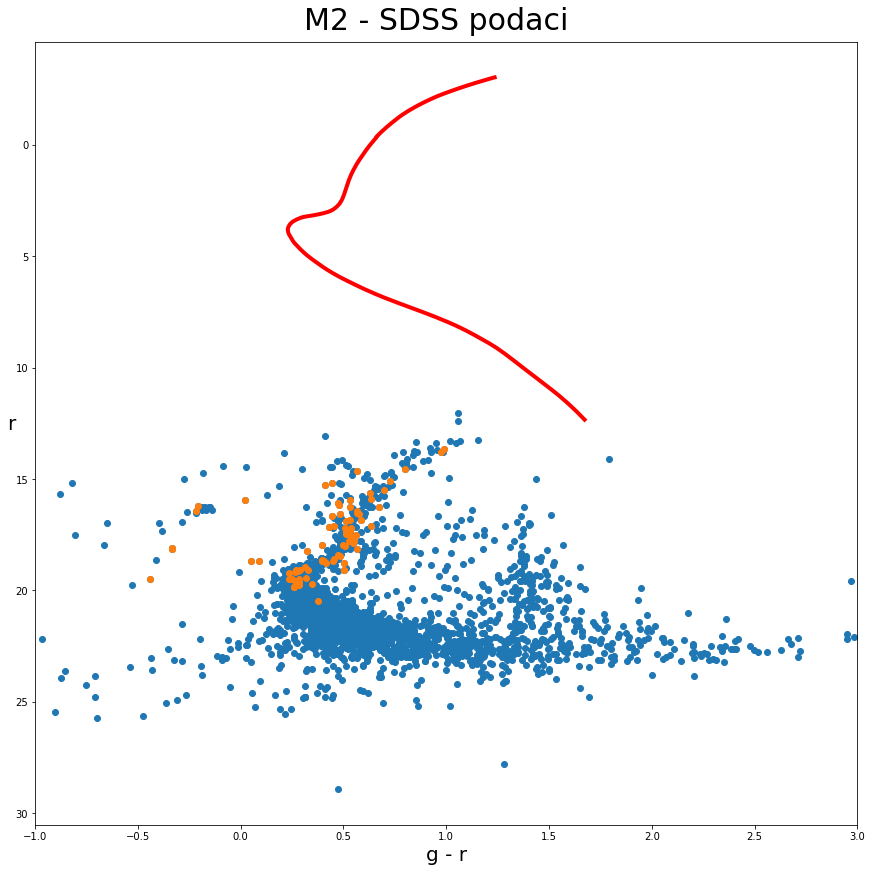

In [12]:
#plotovanje


fig = plt.figure(figsize=(12, 12), layout='constrained')
fig.suptitle(f'M2 - SDSS podaci', fontsize=30)


ax2 = fig.add_subplot(111)
ax2.set_xlim(-1, 3)
#ax2.set_ylim(13.5, 26)
ax2.invert_yaxis()
ax2.scatter((Sdf2a['g'] - Sdf2a['r']), Sdf2a['r'])
ax2.scatter((Sdf2f['g'] - Sdf2f['r']), Sdf2f['r'])
ax2.set_xlabel('g - r',  fontsize=20)
ax2.set_ylabel('r',  fontsize=20, rotation=0)


ax2.plot(iso['sdss_g']-iso['sdss_r'], iso['sdss_r'], 'r', linewidth=4)

plt.show()

## Procena rastojanja zvezda od izohrone (posmatra se glavni niz) u magnitudama (*distance modulus*)

### Suština je da odredimo vrednost tako da se izohrona lepo fituje na podatke

In [10]:
#procena --> 15.75

iso['fit_iso'] = iso['sdss_r'] + 15.75

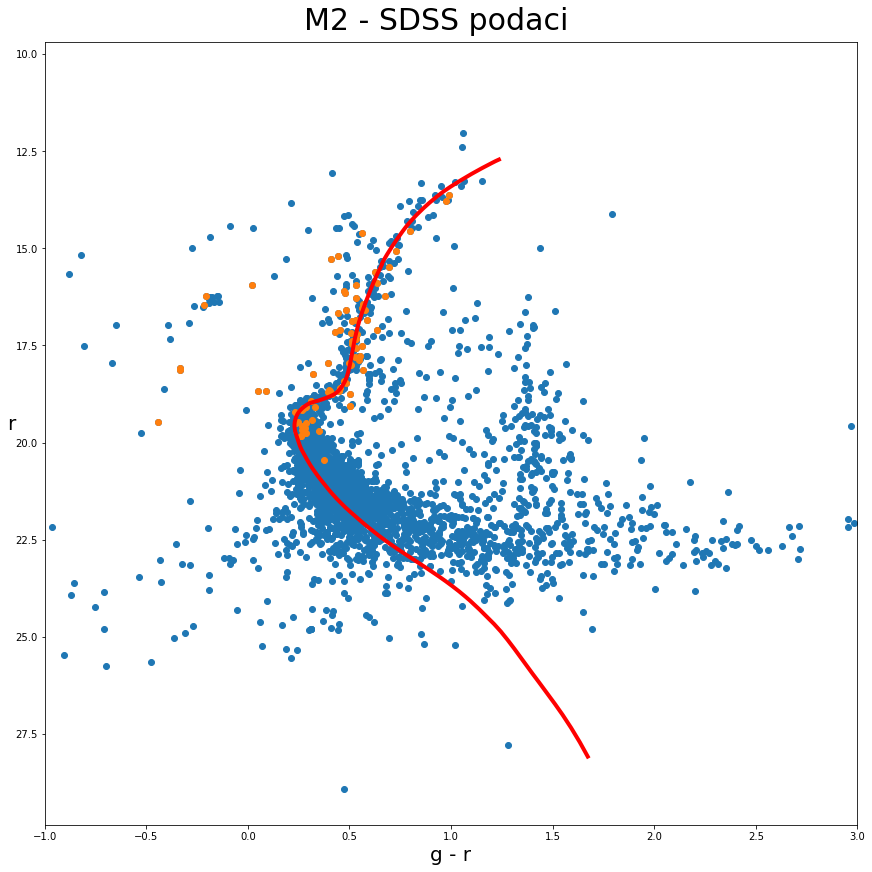

In [11]:
#plotovanje


fig = plt.figure(figsize=(12, 12), layout='constrained')
fig.suptitle(f'M2 - SDSS podaci', fontsize=30)


ax2 = fig.add_subplot(111)
ax2.set_xlim(-1, 3)
#ax2.set_ylim(13.5, 26)
ax2.invert_yaxis()
ax2.scatter((Sdf2a['g'] - Sdf2a['r']), Sdf2a['r'])
ax2.scatter((Sdf2f['g'] - Sdf2f['r']), Sdf2f['r'])
ax2.set_xlabel('g - r',  fontsize=20)
ax2.set_ylabel('r',  fontsize=20, rotation=0)


ax2.plot(iso['sdss_g']-iso['sdss_r'], iso['fit_iso'], 'r', linewidth=4)

plt.show()

## Račun rastojanja iz Pogsonovog zakona

### Zanemarena je ekstinkicija

In [17]:
# racunanje rastojanja iz procene

mu = 15.75

d_e = 10**(mu/5+1)
print(d, 'pc')

14125.375446227554 pc


In [18]:
# rastojanje dobijeno iz HEASARC

d_t = jataR['distance_pc'][0]

### relativna greška rastojanja [%]

In [20]:
delta = abs(d_e - d_t)*100/d_t
print(delta)

22.75463149585082
